## comparison between GP and Kalman filter
In this notebook we compared various performance of GP and kalman filter with martern32 kernel on the same trading dataset, using the sliding window method.

From the result we can see that kalman filter can run much faster than GP, while keep the performance of mean absolute error and model fitness almost the same.

Also, we implemented the online predict with GP, and it worked quite well.

### To do: 
Use other kernels like **spectral mixture kernel**,  or design our own kernel.
Maybe try multiple outputs.

In [1]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import GPy
from scipy.linalg import expm
import math
import scipy
from GPy.kern.src.sde_matern import Matern32

In [2]:
def plot_fit(x,y,mu,var, m_y='k-o', m_mu='b-<', l_y='true', l_mu='predicted', legend=True, title=''):
    """
    Plot the fit of a GP
    """
    if y is not None:
        plt.plot(x,y, m_y, label=l_y)
    plt.plot(x,mu, m_mu, label=l_mu)
    vv = 2*np.sqrt(var)
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
    if legend:
        plt.legend()
    if title != '':
        plt.title(title)

In [3]:
def plot_KF(x, y, predictions, var):
   # show_loc=np.linspace(98,100,5).astype(int)
    fig, ax = plt.subplots(1, 1)

    mu = predictions
    ax.plot(x,y,label="measurement",marker='o')
    ax.plot(x,mu,label="kalman filter")
    vv = 2*np.sqrt(var).reshape(-1)
    ax.fill_between(x.reshape(-1), (mu-vv), (mu+vv), alpha=0.2)
    ax.set_title('Kalman filter result', fontsize=14)
    ax.legend()
    plt.show()

## Offline sliding window predict
Here we use the downloaded offline dataset and predict the trading value using sliding window method.

The sampling frequency is 1 min, which is the smallest frequency that we can get

In the following examples, the sliding window step is 1; the training data length is 100, and the predict length is 10

### 1. GP offline predict

In [4]:
def GP_predict_offline(x, y, ker, train_len = 100, predict_range = 10,  num_restarts = 1 ):

    dqx = deque(x[:train_len], maxlen=train_len)
    dqy = deque(y[:train_len], maxlen=train_len)
    
    predictions = []
    var = []
    log_likelihood = []
    compute_time = []
    # sliding window prediction
    
    for i in range(predict_range):
        time_start=datetime.datetime.now()
        X_train = np.array(dqx)
        y_train = np.array(dqy)

        m = GPy.models.GPRegression(X=X_train, Y=y_train, kernel=ker)
        m.optimize_restarts(num_restarts = num_restarts, messages=False)

        dqx.append(x[train_len + i])
        dqy.append(y[train_len + i])
        mu, V = m.predict(np.array(dqx))
    
        predictions.append(mu[-1])# 
        var.append(V[-1])
        log_likelihood.append(m.log_likelihood())
        
        time_end=datetime.datetime.now()
        # milliseconds
        diff = (time_end - time_start).microseconds/1000
        compute_time.append(diff)
        print('computing time is: {} milliseconds'.format(diff))
        
    plot_fit(x[train_len:train_len+predict_range], y[train_len:train_len+predict_range], predictions, var)
    plt.show()  
    
    print('mean computing time for each step is: {} milliseconds'.format(np.mean(compute_time)))
    MAE = np.mean(abs(y[train_len:train_len+predict_range] - predictions)) 
    print('mean absolute error for the prediction is {}'.format(MAE))
    return predictions, var, log_likelihood, compute_time, MAE

In [5]:
#per = ['m1','m5','m30','h4']
per = 'm1'
data = pd.read_csv(per+'.csv')

# data type
y=data['Open']
# reshape
y = y[:,None] 
x = np.array(range(len(y)))[:,None]
# kernel
# ker = GPy.kern.RBF(1)
ker = Matern32(1)

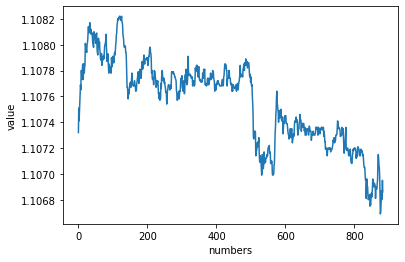

In [6]:
plt.plot(x, y)
plt.ylabel('value')
plt.xlabel('numbers')
plt.show()

 C:\Users\31626\AppData\Local\Continuum\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\31626\AppData\Local\Continuum\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\31626\AppData\Local\Continuum\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/3, f = -785.1338645129006
Optimization restart 2/3, f = -786.2967021223106
Optimization restart 3/3, f = -786.2967018696019
computing time is: 579.514 milliseconds
Optimization restart 1/3, f = -786.8519357249567


 C:\Users\31626\AppData\Local\Continuum\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/3, f = -786.8519359029729
Optimization restart 3/3, f = -786.8519348743624
computing time is: 643.499 milliseconds
Optimization restart 1/3, f = -786.7332253309792
Optimization restart 2/3, f = -786.7337924595593
Optimization restart 3/3, f = -786.733792672582
computing time is: 660.663 milliseconds
Optimization restart 1/3, f = -787.5705035715177
Optimization restart 2/3, f = -784.4359090679269
Optimization restart 3/3, f = -787.5754957691818
computing time is: 200.676 milliseconds
Optimization restart 1/3, f = -788.2212679210758
Optimization restart 2/3, f = -788.2212681535792
Optimization restart 3/3, f = -788.221268082991
computing time is: 783.148 milliseconds
Optimization restart 1/3, f = -788.5216930678772
Optimization restart 2/3, f = -788.5216973033573
Optimization restart 3/3, f = -788.5216969220696
computing time is: 726.411 milliseconds
Optimization restart 1/3, f = -788.3632263985617
Optimization restart 2/3, f = -788.364312300634
Optimization restar

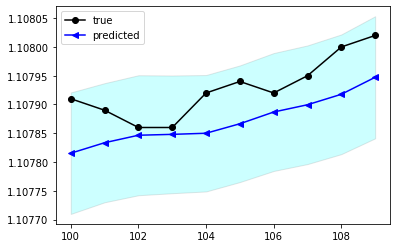

mean computing time for each step is: 619.9912 milliseconds
mean absolute error for the prediction is 5.584468961197242e-05


In [7]:
# GP offline predict
train_len = 100
predict_len = 10
num_restarts = 3
predictions, var, log_likelihood_GP , compute_time_GP, MAE_GP = GP_predict_offline(x,y,ker,train_len = train_len, predict_range = predict_len,  num_restarts = num_restarts)

### 2.Kalman filter offline predict

In [8]:
# matern 3/2 Covariance matrix
def cov_m(t1, t2, l):

    K = np.zeros([len(t1), len(t2)])
    for i in range(len(t1)):
        for j in range(len(t2)): 
            r = abs(t1[i] - t2[j])
            K[i,j]=  (1 + np.sqrt(3)*r/l)* np.exp((-np.sqrt(3)) * r / l)
    return K

In [9]:
# Kalman filter and smoother for state space posterior calc
def kalmanSmoother(A,Q,H,P,vary,y):
    T = len(y)
    s_ = np.full([T,1], np.nan)
    v_ = np.full([T,1], np.nan)
    a = np.full([T,1], np.nan)
    Y = np.reshape(y,(1,1,T))
    lik=0
    
    vary = vary * np.ones((T,1))
    
    #if vary == 1:
        #vary = vary * np.ones((T,1))
        
    m = np.zeros((A.shape[0],1))
    MS = np.zeros((m.shape[0],Y.shape[2]))
    PS = np.zeros((m.shape[0],m.shape[0],Y.shape[2]))
    Pfin = np.zeros((Y.shape[2],np.sum(H)))
    
    ### Forward filter
    for k in range(T):
        
        R = vary[k]
        # Prediction
        if k>0:

            m = A.dot(m)
            
            P = (A.dot(P)).dot(A.T) + Q
         
        #Kalman update
        if np.isnan(Y[0,0,k])==False:

            S = (H.dot(P)).dot(H.T) + R  
            s_[k] = S
            
            K = P.dot(H.T)/S

            v = Y[:,:,k]-H.dot(m)


            
            v_[k] = v
            a[k] = v/S

            m = m + K*v
            
            P = P - (K.dot(H)).dot(P)

         # Evaluate the energy (neg. log lik): Check this  ???
            lik = lik + 0.5*S.shape[0]*np.log(2*math.pi) + 0.5*np.log(S) + 0.5*(v.dot(v))/S
            
        
        
        PS[:,:,k] = P
        MS[:,k]=np.reshape(m,-1)
        Pfin[k,:] = P[0,0]

    # ### Backward smoother
    for k in range(MS.shape[1]-1,1,-1):
        
        # Smoothing step (using Cholesky for stability)
        PSk = PS[:,:,k]
        # Pseudo-prediction
        PSkp = (A.dot(PSk)).dot(A.T)+ Q

        L= np.linalg.cholesky(PSkp)# Solve the Cholesky factorization
        # Continue smoothing step
        G = (PSk.dot(A.T)).dot(np.linalg.inv(L.T)).dot(np.linalg.inv(L))
        # Do update

        m = MS[:,k].reshape(MS[:,k].shape[0],1) + G.dot((m-A.dot(MS[:,k].reshape(MS[:,k].shape[0],1))))

        P = PSk + (G.dot(P-PSkp)).dot(G.T)

        MS[:,k] = m.reshape(1, m.shape[0])
        PS[:,:,k] = P
        Pfin[k,:] = P[0,0]

    lik = -lik
    MSF = MS.copy()
    PSF = PS[1,1,:]
    PfinF = Pfin.copy()
    
    # Xfin = MS.reshape(1,MS.shape[0],MS.shape[1])
    # #print(Xfin.shape)
    # Xfin = np.squeeze(Xfin).T

    return lik, MSF, PfinF

In [10]:
def KF_predict_offline(x, y, train_len = 100, predict_range = 10):
    #kalman filter initialization

    
    
    dqx = deque(x[:train_len+1], maxlen=train_len+1)
    dqy = deque(y[:train_len+1], maxlen=train_len+1)
    
    predictions = []
    var = []
    log_likelihood = []
    compute_time = []

    
    # sliding window prediction
    
    for i in range(predict_range):
        time_start=datetime.datetime.now()
        X_train = np.array(dqx)
        y_train = np.array(dqy)
        
        y_train=np.reshape(np.array(dqy),-1)
        y_kf=y_train
        
        likelihood,MSF, PSF, = kalmanSmoother(A,Q,H,P,var_y,y_kf)

        dqx.append(x[train_len + i])
        dqy.append(y[train_len + i])
        mu, V = MSF[0,-1], PSF[-1]
        predictions.append(mu)# 
        var.append(V)
        log_likelihood.append(likelihood)
        
        time_end=datetime.datetime.now()
        # milliseconds
        diff = (time_end - time_start).microseconds/1000
        compute_time.append(diff)
#         print('computing time is: {} milliseconds'.format(diff))
        
    var = np.array(var).reshape(-1)
    plot_KF(x[train_len:train_len+predict_range], y[train_len:train_len+predict_range], predictions, var)
    plt.show()  
    print('mean computing time is: {} milliseconds'.format(np.mean(compute_time)))
   
    MAE = np.mean(abs(y[train_len:train_len+predict_range] - predictions)) 
    print('mean absolute error for the prediction is {}'.format(MAE))
    return predictions, var, log_likelihood, compute_time, MAE
    

In [11]:
#load data
#per = ['m1','m5','m30','h4']
per = 'm1'
data = pd.read_csv(per+'.csv')[:110]
y=data['Open']
y = y[:,None] #选哪段数据出来
x = np.array(range(len(y)))[:,None]
# ker = GPy.kern.RBF(1)

In [12]:
l = 5
var = 0.0001**2
A_ = np.array([[0,1],[-(np.sqrt(3)/l)**2,2*(-np.sqrt(3))/l]]) #F
A = expm(A_)
H = np.array([[1,0]])
P = np.array([[1,0],[0,3/l**2]])*var   #Pinf
Q = P - A.dot(P).dot(A.T)
var_y = 0.0001**2

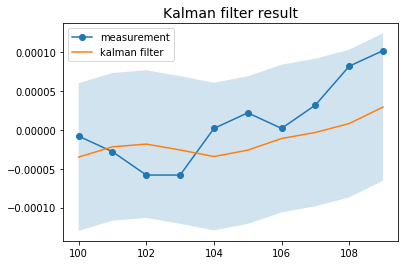

mean computing time is: 20.8519 milliseconds
mean absolute error for the prediction is 4.621789184583332e-05


In [13]:
# offline predict
y=y-np.mean(y)
train_len = 100
predict_len = 10
predictions, var, log_likelihood_FK , compute_time_KF , MAE_KF= KF_predict_offline(x,y,train_len = train_len, predict_range = predict_len)

#### Here we show the comparison resulf between GP and KF

In [14]:
print('Mean log_likelihood of kalman filter is: {}'.format(np.mean(log_likelihood_FK)))
print('Mean log_likelihood of GP is: {}'.format(np.mean(log_likelihood_GP)))
print('Mean computing time of kalman filter is: {}'.format(np.mean(compute_time_KF)))
print('Mean computing time of GP is: {}'.format(np.mean(compute_time_GP)))
print('Mean absolute error for prediction of kalman filter is: {}'.format(np.mean(MAE_KF)))
print('Mean absolute error for prediction of GP is: {}'.format(np.mean(MAE_GP)))

Mean log_likelihood of kalman filter is: 803.2343639515868
Mean log_likelihood of GP is: 787.7767149336212
Mean computing time of kalman filter is: 20.8519
Mean computing time of GP is: 619.9912
Mean absolute error for prediction of kalman filter is: 4.621789184583332e-05
Mean absolute error for prediction of GP is: 5.584468961197242e-05


## Online predict
Here we use the fxcmpy API to download the trading data and predict the trading value. Here we only implemented the GP, actually kalman filter should be the same as GP.

The frequency of traindg data is 1 min, so we update the data every 1 min.

Still, the sliding window step is 1, the training data length is 100, and the predict length is 10

In [15]:
#online predict (max frequency is 1 min)
import fxcmpy
from fxcmpy import fxcmpy_tick_data_reader as tdr
TOKEN = '8fca5c8d5b35bfd530dc58302b553dc03506ed90'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')

In [16]:
def GP_predict_online(ker, train_len = 100, predict_range = 10,  num_restarts = 1 ):
    
    
#     dqx = deque(x[:train_len], maxlen=train_len)
#     dqy = deque(y[:train_len], maxlen=train_len)
    
    predictions = []
    var = []
    log_likelihood = []
    compute_time = []
    # sliding window prediction
    
    for i in range(predict_range):
        time_start=datetime.datetime.now()

        X_train = np.array(range(i,i+train_len))[:,None]
        data = con.get_candles('EUR/USD', period='m1', number=train_len)
        y_train = data[ 'bidopen']
        y_train = y_train[:,None]
        

        m = GPy.models.GPRegression(X=X_train, Y=y_train, kernel=ker)
        m.optimize_restarts(num_restarts = num_restarts, messages=False)

        X_predict = np.array(range(i,i + train_len + 1))[:,None]
        mu, V = m.predict(X_predict)
    
        predictions.append(mu[-1])# 
        var.append(V[-1])
        log_likelihood.append(m.log_likelihood())
        
        time_end=datetime.datetime.now()
        # milliseconds
        diff = (time_end - time_start).microseconds/1000
        compute_time.append(diff)
        print('computing time is: {} milliseconds'.format(diff))
        
        print('sleep 60 s for the update')
        time.sleep(60)
    data = con.get_candles('EUR/USD', period='m1', number=train_len + predict_range)
    
    x = np.array(range(predict_range))[:,None]
    y = data[ 'bidopen'].values[-predict_range:]
    plot_fit(x, y, predictions, var)
    plt.show()  
    

    print('mean computing time for each step is: {} milliseconds'.format(np.mean(compute_time)))
    MAE = np.mean(abs(y - predictions)) 
    print('mean absolute error for the prediction is {}'.format(MAE))
    return predictions, var, log_likelihood, compute_time, MAE

Optimization restart 1/3, f = -629.7854939451192
Optimization restart 2/3, f = -616.5120371936378
Optimization restart 3/3, f = -616.5120356578216
computing time is: 224.609 milliseconds
sleep 60 s for the update
Optimization restart 1/3, f = -629.7761645445731
Optimization restart 2/3, f = -616.2055320890141
Optimization restart 3/3, f = -616.205530450697
computing time is: 53.405 milliseconds
sleep 60 s for the update
Optimization restart 1/3, f = -627.5491910573968
Optimization restart 2/3, f = -614.8485264397057
Optimization restart 3/3, f = -614.8485252847044
computing time is: 92.289 milliseconds
sleep 60 s for the update
Optimization restart 1/3, f = -627.985010995644
Optimization restart 2/3, f = -614.9372160783566
Optimization restart 3/3, f = -614.9372151278016
computing time is: 137.199 milliseconds
sleep 60 s for the update
Optimization restart 1/3, f = -628.2033940405556
Optimization restart 2/3, f = -615.1570101576214
Optimization restart 3/3, f = -615.1570099258377
compu

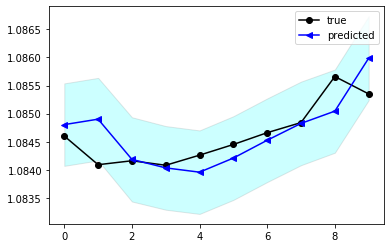

mean computing time for each step is: 248.0027 milliseconds
mean absolute error for the prediction is 0.0006060598556510178


In [18]:
# set the length of training data and predict data
train_len = 100
predict_len = 10
num_restarts = 3
# online predict
predictions, var, log_likelihood_GP , compute_time_GP, MAE_GP = GP_predict_online(ker,train_len = train_len, predict_range = predict_len,  num_restarts = num_restarts)